In [2]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, random
from jax.example_libraries import optimizers

import neural_tangents as nt
from neural_tangents import stax

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

seed=24

In [3]:
# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train/255, x_test/255
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

dsize = 128

choices = random.choice(random.key(0), jnp.arange(len(x_train)), (dsize,))

x_train_sub, y_train_sub = x_train[choices], y_train[choices]
x_train_sub = x_train_sub.reshape(-1, 784)
x_test = x_test.reshape(-1,784)

In [27]:
# Define NN using nt.stax

def build_nn(size, wstd=1, bstd=0):
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(size, W_std=wstd, b_std=bstd), stax.Relu(),
        stax.Dense(size, W_std=wstd, b_std=bstd), stax.Relu(),
        stax.Dense(size, W_std=wstd, b_std=bstd), stax.Relu(),
        stax.Dense(10), stax.Exp()     
    )

    empirical_kernel_fn = nt.empirical_kernel_fn(
        apply_fn, trace_axes=(), vmap_axes=0,
        implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES
    )
    return init_fn, apply_fn, kernel_fn, empirical_kernel_fn


def logsoftmax(x):
    return x - jnp.log(jnp.sum(jnp.exp(x),axis=1))[:,jnp.newaxis]

def predict(apply_fn, params, x):
    logits = apply_fn(params, x)
    return logits/jnp.sum(logits, axis=1)[:,jnp.newaxis]

In [28]:
# Build Neural Network
init_fn, apply_fn, kernel_fn, empirical_kernel_fn = build_nn(128)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')
empirical_kernel_fn = jit(empirical_kernel_fn, static_argnames='get')

In [29]:
# Get initial kernels and parameters
_, params = init_fn(random.key(seed), (784,))
T0 = empirical_kernel_fn(x_train_sub, x_train_sub, 'ntk', params)
K0 = empirical_kernel_fn(x_train_sub, x_train_sub, 'nngp', params)
p0 = params

In [30]:
# Create optimiser to train model with
learning_rate=1

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

In [31]:
# Define loss function and gradients
loss = lambda params, x, y: jnp.mean(0.5*jnp.linalg.norm(y-predict(apply_fn, params, x), axis=1))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

In [35]:
epochs=2**12
opt_state = opt_init(params)

train_losses=[]
accuracies = []

for i in range(epochs):
    opt_state = opt_update(i, grad_loss(opt_state, x_train_sub, y_train_sub), opt_state)
    train_losses += [loss(get_params(opt_state), x_train_sub, y_train_sub)]
    accuracies += [jnp.mean(jnp.argmax(predict(apply_fn ,get_params(opt_state), x_train_sub),axis=1)==jnp.argmax(y_train_sub, axis=1))]


In [36]:
# Look at data
print(jnp.argmax(predict(apply_fn, get_params(opt_state), x_train_sub),axis=1))
print(jnp.argmax(y_train_sub, axis=1))
print(loss(params, x_train_sub, y_train_sub))

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 7 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 6 8 8 8 6 8 8 8 8 8 8 8 8 8 8 2]
[8 3 8 1 9 3 8 9 6 5 7 0 6 5 4 7 8 9 8 7 8 4 2 1 3 8 4 8 7 2 0 8 6 2 1 9 2
 6 6 3 6 4 7 0 8 8 1 5 6 2 8 5 1 7 3 1 6 0 9 2 8 8 9 9 9 3 9 9 6 5 2 1 2 7
 1 9 8 0 0 4 2 5 7 8 2 2 9 3 4 2 4 2 8 9 3 7 6 7 8 3 6 2 5 2 4 8 9 2 7 1 5
 7 6 8 0 1 6 6 9 9 9 6 7 3 4 2 6 4]
0.47571042


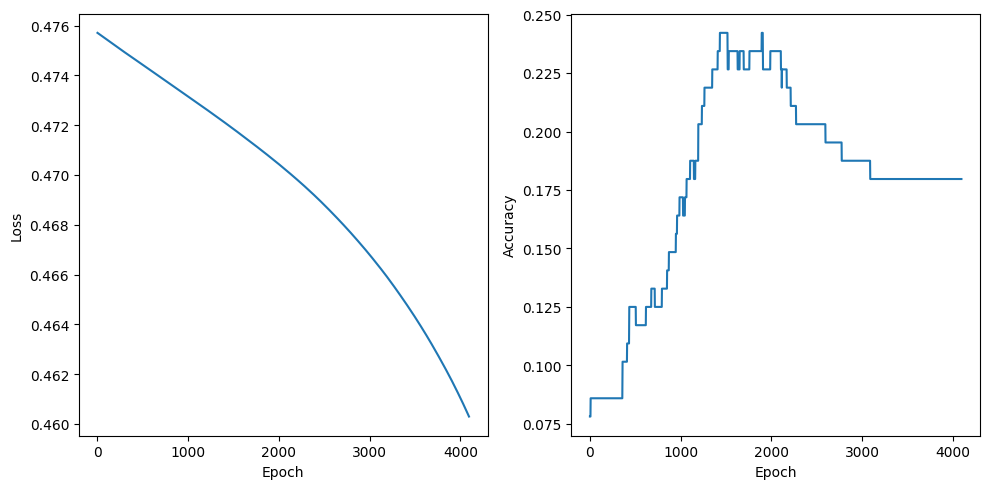

In [37]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10, 5)
axs[0].plot(jnp.arange(epochs), train_losses)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].plot(jnp.arange(epochs), accuracies)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [12]:
print(jnp.linalg.norm(T0-empirical_kernel_fn(x_train_sub, x_train_sub, 'ntk', get_params(opt_state)))/jnp.linalg.norm(T0))

0.27959356


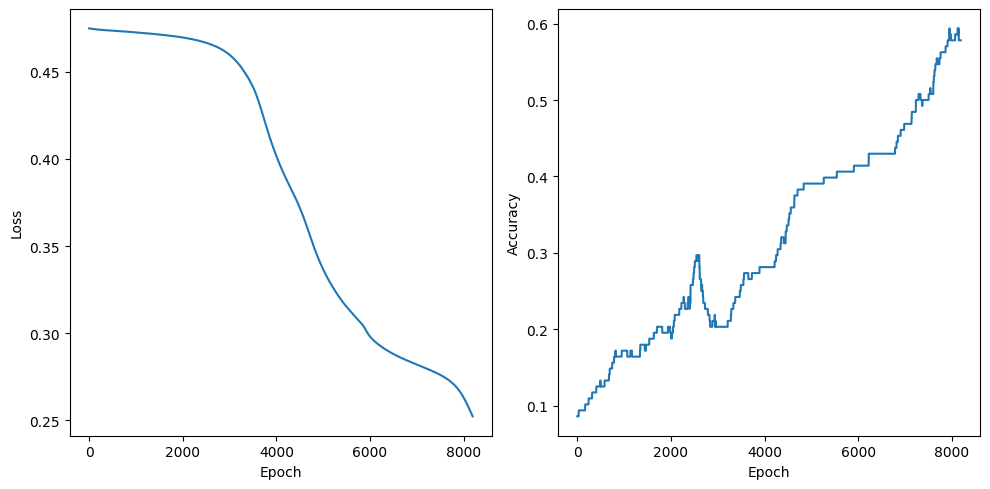

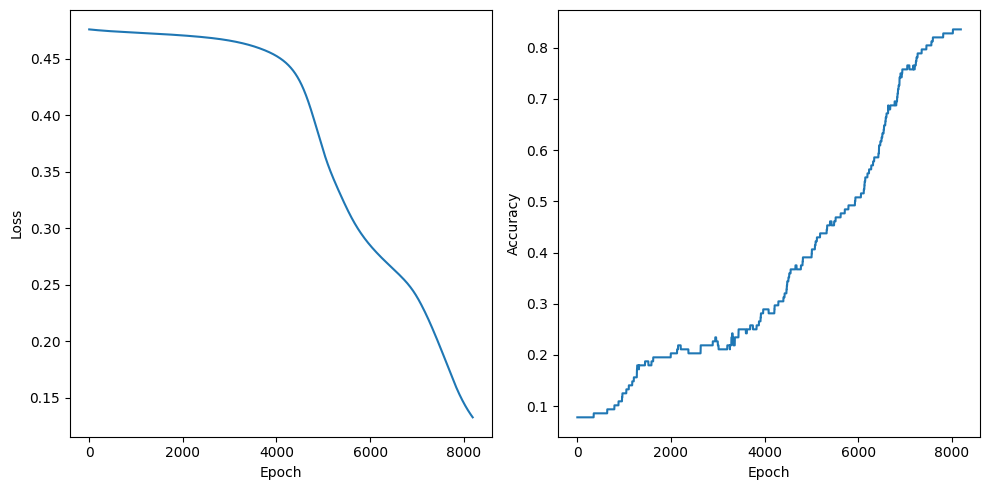

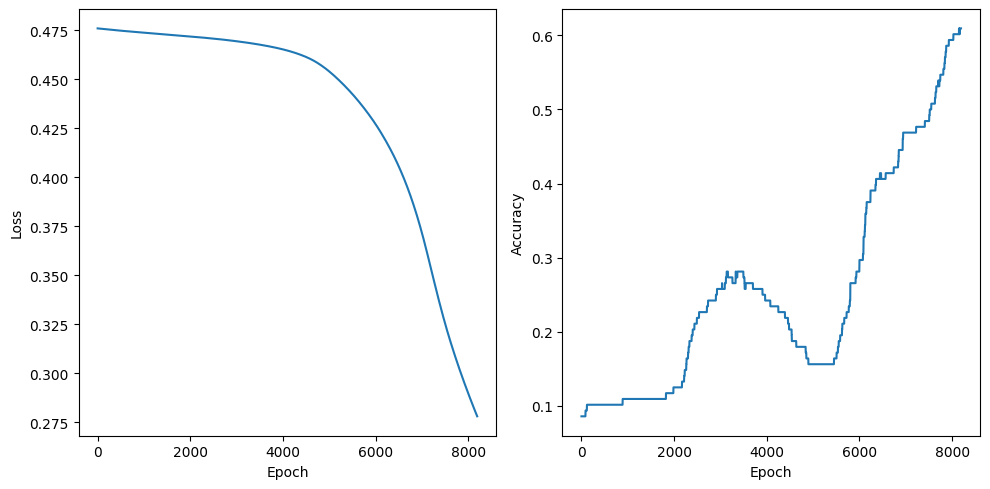

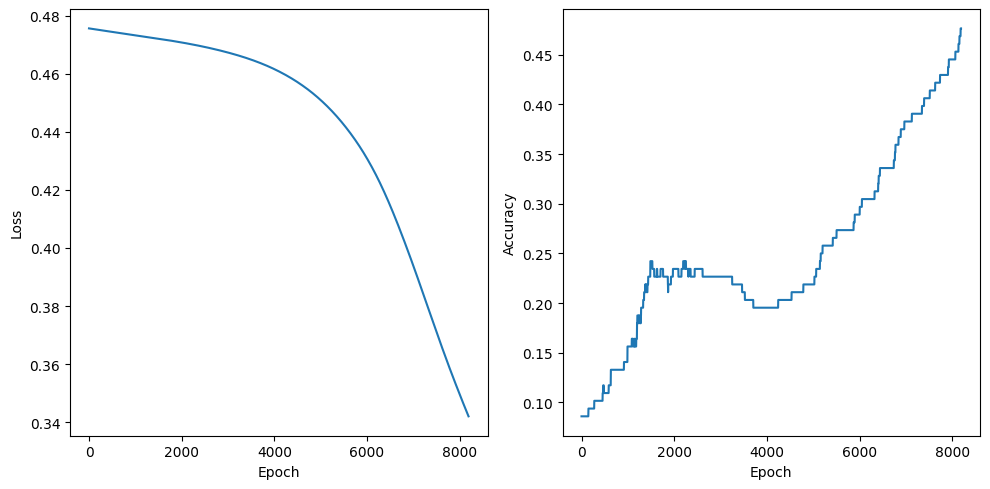

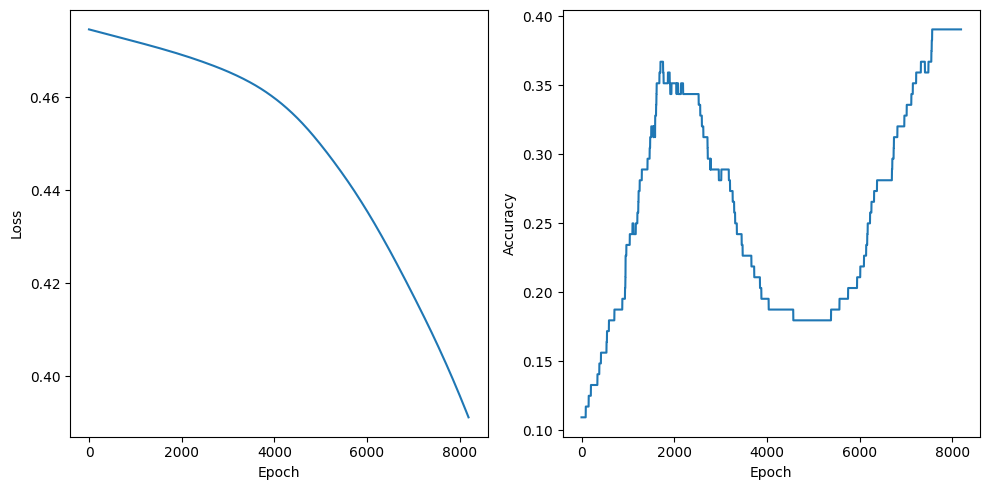

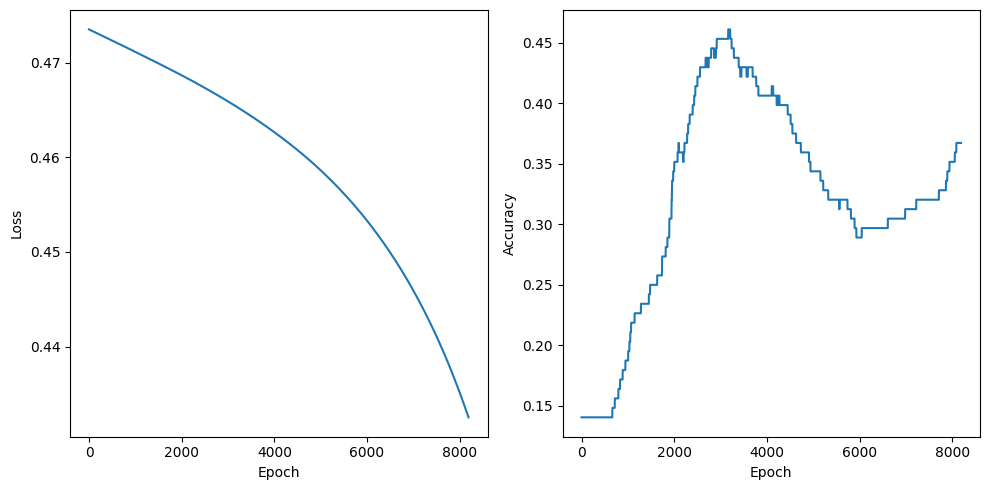

In [40]:
ns = [16,32,64,128,256,512]

ps = []
Ts = []
Ks = []

for n in ns:
    # Build Neural Network
    init_fn, apply_fn, kernel_fn, empirical_kernel_fn = build_nn(n, bstd=0.05)

    apply_fn = jit(apply_fn)
    kernel_fn = jit(kernel_fn, static_argnames='get')
    empirical_kernel_fn = jit(empirical_kernel_fn, static_argnames='get')
    
    # Get initial kernels and parameters
    _, params = init_fn(random.key(seed), (784,))
    T0 = empirical_kernel_fn(x_train_sub, x_train_sub, 'ntk', params)
    K0 = empirical_kernel_fn(x_train_sub, x_train_sub, 'nngp', params)
    p0 = params

    # Create optimiser to train model with
    learning_rate=1

    opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
    opt_update = jit(opt_update)

    epochs=2**13
    opt_state = opt_init(params)

    train_losses=[]
    accuracies = []

    for i in range(epochs):
        opt_state = opt_update(i, grad_loss(opt_state, x_train_sub, y_train_sub), opt_state)
        train_losses += [loss(get_params(opt_state), x_train_sub, y_train_sub)]
        accuracies += [jnp.mean(jnp.argmax(predict(apply_fn ,get_params(opt_state), x_train_sub),axis=1)==jnp.argmax(y_train_sub, axis=1))]

    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(10, 5)
    axs[0].plot(jnp.arange(epochs), train_losses)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[1].plot(jnp.arange(epochs), accuracies)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

    
    Ts.append(jnp.linalg.norm(T0-empirical_kernel_fn(x_train_sub, x_train_sub, 'ntk', get_params(opt_state)))/jnp.linalg.norm(T0))
    Ks.append(jnp.linalg.norm(K0-empirical_kernel_fn(x_train_sub, x_train_sub, 'nngp', get_params(opt_state)))/jnp.linalg.norm(K0))


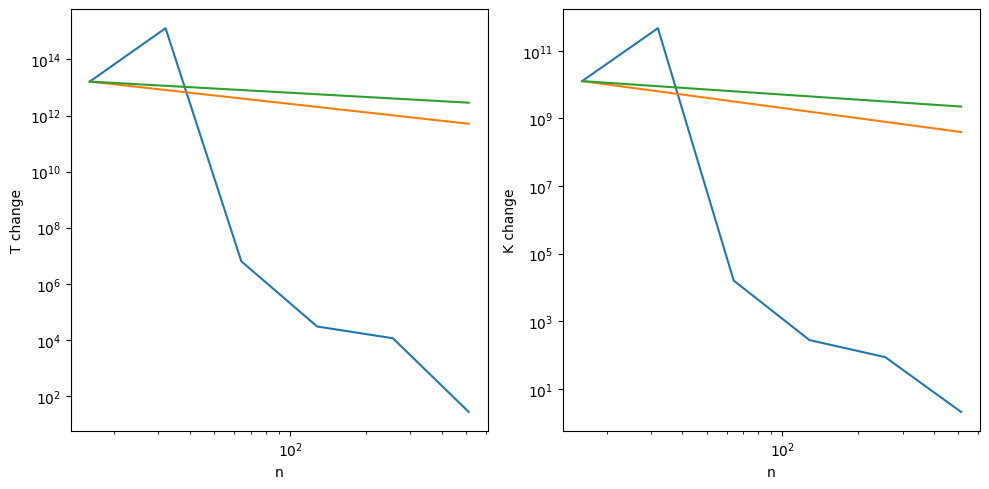

In [41]:
fig, [ax1, ax2] = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax1.loglog(ns, Ts)
ax1.loglog(ns, Ts[0]*ns[0]/jnp.array(ns))
ax1.loglog(ns, Ts[0]*jnp.sqrt(ns[0])/jnp.sqrt(jnp.array(ns)))
ax1.set_xlabel("n")
ax1.set_ylabel("T change")

ax2.loglog(ns, Ks)
ax2.loglog(ns, Ks[0]*ns[0]/jnp.array(ns))
ax2.loglog(ns, Ks[0]*jnp.sqrt(ns[0])/jnp.sqrt(jnp.array(ns)))
ax2.set_xlabel("n")
ax2.set_ylabel("K change")

plt.tight_layout()
plt.show()